In [2]:
%matplotlib inline
import codecs
import numpy as np
import math
from matplotlib import pyplot as plt
from matplotlib import cm
import cv2
import h5py
def get_ellipselist(filename):
    raws = []
    with codecs.open(filename, 'r', encoding='utf8') as f:
        start_head = False
        start_record = False
        nline = 0
        nbatch = 0
        batch = []
        name = ''
        for line in f.readlines():
            if start_record:
                batch.append([float(x) for x in line.split(' ')[:-2]])
                nbatch += 1
                if nbatch >= nline:
                    a_list, b_list, angle_list, h_list, k_list = [], [], [], [], []
                    for i in xrange(nline):
                        a_list.append(batch[i][0])
                        b_list.append(batch[i][1])
                        angle_list.append(batch[i][2])
                        h_list.append(batch[i][3])
                        k_list.append(batch[i][4])

                    raws.append({'imgfile':name, 'a_list':a_list, 'b_list':b_list,\
                                 'angle_list':angle_list, 'h_list':h_list, 'k_list':k_list})
                    start_head = False
                    start_record = False
            elif start_head:            
                nline = int(line)
                nbatch = 0
                batch = []
                start_record = True
            else:
                name = line[:-1]
                if name.find('/') > 0:
                    start_head = True
    return raws

def get_label_arr(shape_2d, a_list, b_list, angle_list, h_list, k_list):
    arr = np.zeros(shape_2d)
    n = len(a_list)
    a2, b2, a2b2, cos_, sin_, h_, k_ = [], [], [], [], [], [], []

    for i in xrange(n):
        a2.append(a_list[i] ** 2)
        b2.append(b_list[i] ** 2)
        a2b2.append(a2[i] * b2[i])
        cos_.append(math.cos(angle_list[i]))
        sin_.append(math.sin(angle_list[i]))
        h_.append(h_list[i] * cos_[i] + k_list[i] * sin_[i])
        k_.append(-h_list[i] * sin_[i] + k_list[i] * cos_[i])
    
    height, width = shape_2d
    for x in xrange(int(width)):
        for y in xrange(int(height)):
            for i in xrange(n):                
                x_ =  cos_[i] * x + sin_[i] * y
                y_ = -sin_[i] * x + cos_[i] * y
                if (b2[i] * (x_ - h_[i])**2 + a2[i] * (y_ - k_[i])**2) <= a2b2[i]:
                    arr[y, x] = 255.
                    break
    return arr

def normalize_img(img, scale):
    ndim = len(img.shape)
    if ndim > 3 or ndim < 2:
        return 
    elif ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h, w = img.shape
    if w != h:
        print 'error: not square'
        return
    dark, bright = float(img.min()), float(img.max())
#     if bright != 255. and dark != 0.:
    if bright > 0 and bright != dark:
        img = (img - dark) / (bright - dark)
    else:
        img[:] = 0
    return cv2.resize(img,(scale, scale), interpolation = cv2.INTER_AREA)


def get_fold_tuple(nb_fold):
    raws = get_ellipselist('FDDB-folds/FDDB-fold-' + str(nb_fold).zfill(2) + '-ellipseList.txt')
    nb_samples = len(raws)
    x_list = []
    y_list = []
    scale = 128
    y_scale = 16
    for raw in raws:
        img = cv2.cvtColor(cv2.imread('originalPics/' + raw['imgfile'] + '.jpg'), cv2.COLOR_BGR2GRAY)
        label = get_label_arr(img.shape, raw['a_list'], raw['b_list'],\
                    raw['angle_list'], raw['h_list'], raw['k_list'])
        height, width = label.shape
        if height > width:
            window_size = width
            wh_radio = float(height) / float(width)
        else:
            window_size = height
            wh_radio = float(width) / float(height)
        x_list.append(normalize_img(img[:window_size,:window_size], scale))
        y_list.append(normalize_img(label[:window_size,:window_size], y_scale).flatten())
#         if wh_radio > 1.2:
#             x_list.append(normalize_img(img[-window_size:,-window_size:], scale))
#             y_list.append(normalize_img(label[-window_size:,-window_size:], scale).flatten())
#             nb_samples += 1
    X = np.zeros((nb_samples, scale, scale, 1))
    Y = np.zeros((nb_samples, y_scale * y_scale))
    
    for i in xrange(nb_samples):
        X[i,:,:,0] = x_list[i]
        Y[i, :] = y_list[i]
    return (X, Y)

def get_fold_h5f(nb_fold):
    h5f = h5py.File('originalPics/data.h5','r')
    X = h5f['fddb_fold' + str(nb_fold) + '_X'][:]
    Y = h5f['fddb_fold' + str(nb_fold) + '_Y'][:]
    h5f.close()
    return (X, Y)
    
# The generator is expected to loop over its data indefinitely. 
# An epoch finishes when 'samples_per_epoch' samples have been seen by the model.
def get_training_generator(fold_list):
    while 1:
        for i in fold_list:
            X, Y = get_fold_h5f(i)
            n, _, _, _ = X.shape
            p = np.random.permutation(n)
            X = X[p,:,:,:]
            Y = Y[p,:]
            yield (X, Y)
        

In [19]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

batch_size = 128
nb_classes = 10
nb_epoch = 3

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 8

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

model = Sequential()

model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
                        border_mode='valid',
                        input_shape=(1, img_rows, img_cols)))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])


('X_train shape:', (60000, 1, 28, 28))
(60000, 'train samples')
(10000, 'test samples')
Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 196s - loss: 0.3323 - acc: 0.8970 - val_loss: 0.0848 - val_acc: 0.9741
Epoch 2/3
60000/60000 [==============================] - 185s - loss: 0.1207 - acc: 0.9640 - val_loss: 0.0565 - val_acc: 0.9802
Epoch 3/3
60000/60000 [==============================] - 201s - loss: 0.0917 - acc: 0.9727 - val_loss: 0.0468 - val_acc: 0.9855
('Test score:', 0.046816775716014669)
('Test accuracy:', 0.98550000000000004)


In [52]:
import h5py
h5f = h5py.File('originalPics/data.h5', 'w')
for i in xrange(10):
    X, Y = get_fold_tuple(i + 1)
    h5f.create_dataset('fddb_fold' + str(i + 1) + '_X', data = X)
    h5f.create_dataset('fddb_fold' + str(i + 1) + '_Y', data = Y)
    print 'fold ' + str(i + 1) + ' is written into hdf5' 
    i += 1
h5f.close()

fold 1 is written into hdf5
fold 2 is written into hdf5
fold 3 is written into hdf5
fold 4 is written into hdf5
fold 5 is written into hdf5
fold 6 is written into hdf5
fold 7 is written into hdf5
fold 8 is written into hdf5
fold 9 is written into hdf5
fold 10 is written into hdf5


In [3]:
from keras.models import Sequential
from keras.utils.visualize_util import plot as kplot
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.models import model_from_json
filter_size = 8
model = Sequential()
# input: 128x128 images with 1 channels -> (100, 100, 1) tensors.
# this applies 32 convolution filters of size 3x3 each.
model.add(Convolution2D(64, filter_size, filter_size, border_mode='valid',\
                        input_shape=(128, 128, 1), dim_ordering='tf'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))
model.add(Convolution2D(16, filter_size, filter_size, dim_ordering='tf'))
model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))
# model.add(Convolution2D(8, filter_size, filter_size, dim_ordering='tf'))
# model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))
model.add(Convolution2D(4, filter_size, filter_size, dim_ordering='tf'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(16*16))
model.add(Activation('sigmoid'))
model.summary()

Using Theano backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 121, 121, 64)  4160        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 121, 121, 64)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 60, 60, 64)    0           activation_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 53, 53, 16)    65552       maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [54]:
model.compile(loss='mean_squared_error', optimizer='adadelta')

In [63]:
model = model_from_json(open('fddb_model_arch.json').read())
model.load_weights('fddb_model_weights.h5')
model.compile(optimizer='adagrad', loss='mse')
training_gen = get_training_generator(range(1, 10))
Xv, Yv = get_fold_h5f(10)

for i in xrange(25):
    model.fit_generator(training_gen, samples_per_epoch=128, nb_epoch=20, verbose=0)
    print 'loss in validation set: ', model.evaluate(Xv, Yv, verbose=0)

json_string = model.to_json()
open('fddb_model_arch.json', 'w').write(json_string)
model.save_weights('fddb_model_weights.h5', overwrite=True)

loss in validation set:  0.0934890617217
loss in validation set:  0.0834628731012
loss in validation set:  0.0794090004904
loss in validation set:  0.073081307326
loss in validation set:  0.0673554011754
loss in validation set:  0.0707012813006
loss in validation set:  0.0630516975054
loss in validation set:  0.0660612226597
loss in validation set:  0.0624958028751
loss in validation set:  0.063581876776
loss in validation set:  0.0618242105203
loss in validation set:  0.0601153023541
loss in validation set:  0.0597645337028
loss in validation set:  0.059981779222
loss in validation set:  0.0602918760053
loss in validation set:  0.0591018767229
loss in validation set:  0.0598753025489
loss in validation set:  0.0591751729803
loss in validation set:  0.058607956022
loss in validation set:  0.0579955023314
loss in validation set:  0.0579395359116
loss in validation set:  0.0579974784383
loss in validation set:  0.0574022952999
loss in validation set:  0.0580100872687
loss in validation s

2/2 [==============================] - 0s


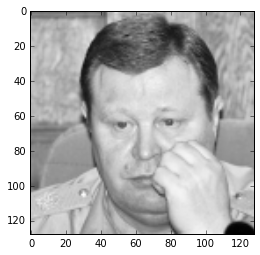

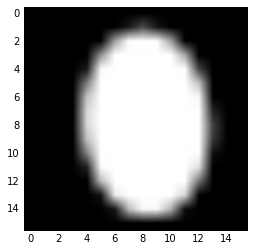

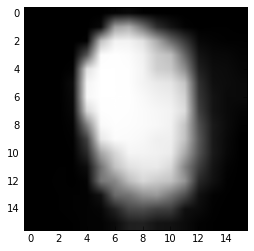

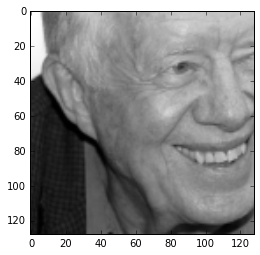

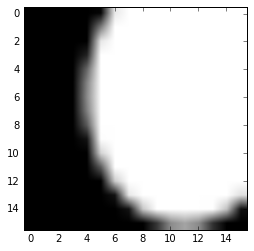

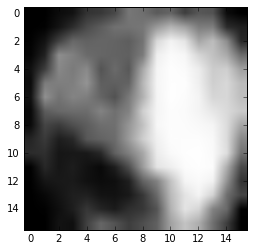

In [65]:
# Yr = model.predict_proba(np.zeros((1,128,128,1)))
Xv, Yv = get_fold_h5f(10)
offset = 151
Yp = model.predict_proba(Xv[offset:offset+2,:,:,:])
# print Yp.shape
# print Yp.min(), Yr.max()


scale = 16
for i in xrange(2):
    plt.figure()
    plt.imshow(Xv[offset + i,:,:,0], cmap=cm.Greys_r)
    plt.figure()
    plt.imshow(Yv[offset + i,:].reshape((scale, scale)), cmap=cm.Greys_r)
    plt.figure()
    Yt = Yp[i,:]
    m, M = Yt.min(), Yt.max()
    Yt = (Yt - m) / (M - m)
    plt.imshow(Yt.reshape((scale, scale)) * 255, cmap=cm.Greys_r)


In [44]:
model = model_from_json(open('fddb_model_arch.json').read())
model.load_weights('fddb_model_weights.h5')
# kplot(model, to_file='fddb_model.png')

In [66]:
W = model.layers[0].W.get_value(borrow=True)


8 8
(71, 71)


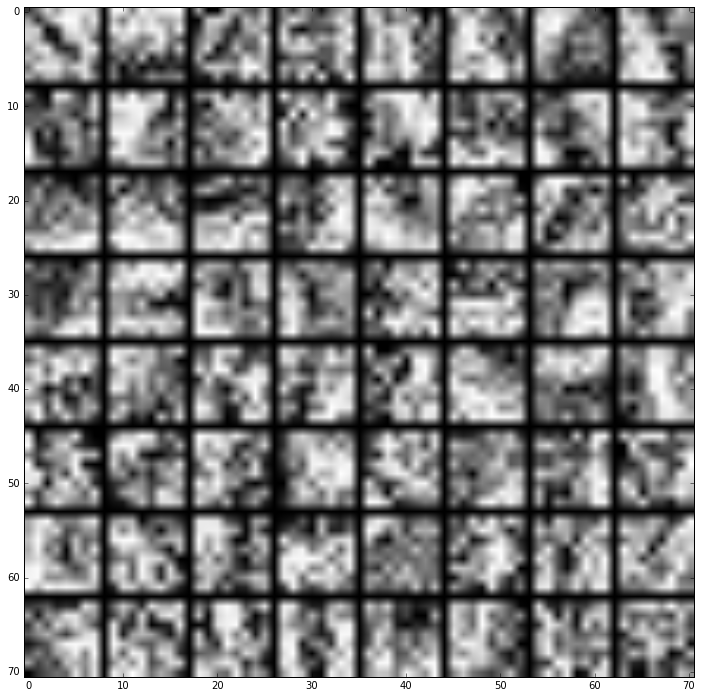

In [67]:
beautiful_plot(W)

In [55]:
import math
def beautiful_plot(w_4d):
    nb_col = 8
    height, width, ch, nb_samples = w_4d.shape
#     nb_samples, ch, height, width = w_4d.shape
    nb_row = int(math.ceil(float(nb_samples) / float(nb_col)))
    print nb_row, nb_col
    space = 1
    big_image = np.zeros((nb_row*height + (nb_row-1)*space, nb_col*width + (nb_col-1)*space))
    print big_image.shape
    rhead = 0
    chead = 0
    
    for i in xrange(nb_samples):
        if i > 0 and (i % nb_col) == 0:
            chead = 0
            rhead += (height + space)
        arr = w_4d[:,:,0,i]
#         arr = w_4d[i,0,:,:]
        m, M = arr.min(), arr.max()
        arr = 255 * (arr - m) / (M - m)
        big_image[rhead : rhead + height, chead : chead + width] = arr
        chead += (width + space)
    plt.figure(figsize=(24,12))
    plt.imshow(big_image.astype('uint8'), cmap=cm.Greys_r)

        

In [111]:
arr = np.zeros((3,2,2))
arr[0,:,:] = np.asarray([[1,1],[1,1]])
arr[1,:,:] = np.asarray([[2,2],[2,2]])
arr[2,:,:] = np.asarray([[3,3],[3,3]])
print arr
print '--------'
i = np.array([2,1,0])
arr2 = arr[i,:,:]
print arr2
print '--------'
n, _, _ = arr.shape
i = np.random.permutation(n)
arr2 = arr[i,:,:]
print arr2
print '--------'
print arr

[[[ 1.  1.]
  [ 1.  1.]]

 [[ 2.  2.]
  [ 2.  2.]]

 [[ 3.  3.]
  [ 3.  3.]]]
--------
[[[ 3.  3.]
  [ 3.  3.]]

 [[ 2.  2.]
  [ 2.  2.]]

 [[ 1.  1.]
  [ 1.  1.]]]
--------
[[[ 2.  2.]
  [ 2.  2.]]

 [[ 1.  1.]
  [ 1.  1.]]

 [[ 3.  3.]
  [ 3.  3.]]]
--------
[[[ 1.  1.]
  [ 1.  1.]]

 [[ 2.  2.]
  [ 2.  2.]]

 [[ 3.  3.]
  [ 3.  3.]]]


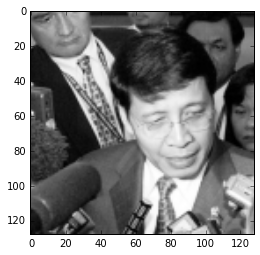

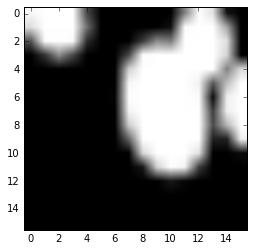

In [6]:
Xv, Yv = get_fold_h5f(10)

offset = 50
i = 5
plt.figure()
plt.imshow(Xv[offset + i,:,:,0], cmap=cm.Greys_r)
plt.figure()
plt.imshow(Yv[offset + i,:].reshape((16, 16)), cmap=cm.Greys_r)

# a = get_fold_tuple(2)
# print a[0].shape, a[1].shape

# offset = 50
# for i in xrange(3):
#     plt.figure()
#     plt.imshow(a[0][offset + i,:,:,0], cmap=cm.Greys_r)
#     plt.figure()
#     plt.imshow(a[1][offset + i,:].reshape((32, 32)), cmap=cm.Greys_r)


450 370


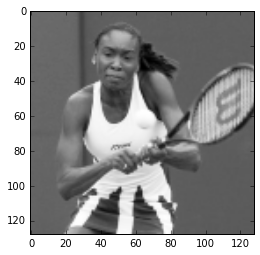

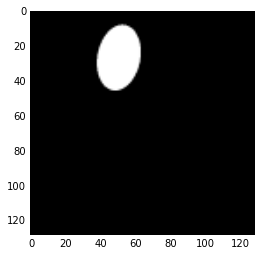

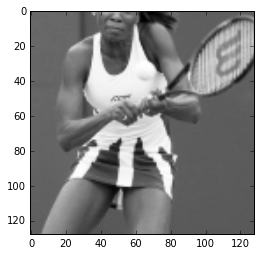

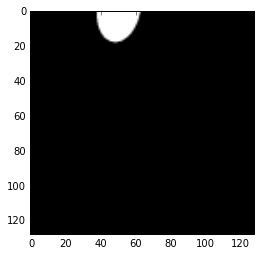

In [9]:
raws = get_ellipselist('FDDB-folds/FDDB-fold-01-ellipseList.txt')
i = 3
img = cv2.cvtColor(cv2.imread('originalPics/' + raws[i]['imgfile'] + '.jpg'), cv2.COLOR_BGR2GRAY)
arr = get_label_arr(img.shape, raws[i]['a_list'], raws[i]['b_list'],\
                    raws[i]['angle_list'], raws[i]['h_list'], raws[i]['k_list'])

height, width = arr.shape
print height, width
window_size = 0.
if height > width:
    window_size = width
else:
    window_size = height
scale = 128
img1 = normalize_img(img[:window_size,:window_size], scale)
img2 = normalize_img(img[-window_size:,-window_size:], scale)
arr1 = normalize_img(arr[:window_size,:window_size], scale)
arr2 = normalize_img(arr[-window_size:,-window_size:], scale)
plt.figure()
plt.imshow(img1, cmap=cm.Greys_r)
plt.figure()
plt.imshow(arr1, cmap=cm.Greys_r)
plt.figure()
plt.imshow(img2, cmap=cm.Greys_r)
plt.figure()
plt.imshow(arr2, cmap=cm.Greys_r)
#intensity = 0.2989*red + 0.5870*green + 0.1140*blue

In [13]:
# t = raws[1]['a_list']
# s = [float(x) for x in t]
# print s
print img1.max(), arr1.max(), img2.max(), arr2.max()

0.983636360851 1.00000005402 0.983641058608 1.00000005588


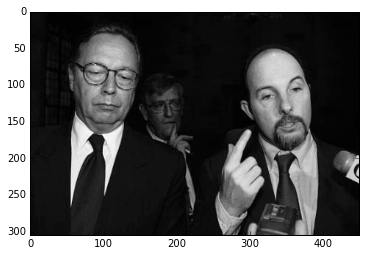

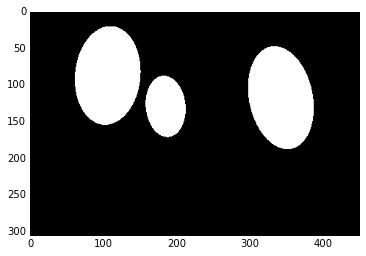

In [10]:
# Read and reformat ellipseList.txt
raws = get_ellipselist('FDDB-folds/FDDB-fold-01-ellipseList.txt')
raws[1]
img = cv2.cvtColor(cv2.imread('originalPics/' + raws[1]['imgfile'] + '.jpg'), cv2.COLOR_BGR2GRAY)
arr = get_label_arr(img.shape, raws[1]['a_list'], raws[1]['b_list'],\
                    raws[1]['angle_list'], raws[1]['h_list'], raws[1]['k_list'])
plt.figure()
plt.imshow(img, cmap=cm.Greys_r)
plt.figure()
plt.imshow(arr, cmap=cm.Greys_r)

In [3]:
# Read image and show
img = cv2.cvtColor(cv2.imread('originalPics/2002/08/12/big/img_821.jpg'), cv2.COLOR_BGR2RGB)
arr = get_label_arr(img[:,:,0].shape, [145.527525], [96.0408], [-1.518437], [178.25], [202.])
# print img[:,:,0].shape
# plt.figure()
# plt.imshow(img[:,:,0], cmap=cm.Reds_r)
# plt.figure()
# plt.imshow(img[:,:,1], cmap=cm.Greens_r)
# plt.figure()
# plt.imshow(img[:,:,2], cmap=cm.Blues_r)

# The coordinate operations in image and numpy array
# arr = np.zeros((300,400))
# for x in xrange(400):
#     for y in xrange(300):
#         arr[y,x] = (x**2 + y**2)**0.5 % 255
# plt.imshow(arr)

# print img.shape
# print arr.shape
# plt.figure()
# plt.imshow(img)
# plt.figure()
# plt.imshow(arr, cmap=cm.Greys_r)